In [1]:
#1st model 
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

# Parameters
L = 4000
hbar = 1
x0 = 200
k0_values = [0.0, 0.1, 0.2] 
E_values = np.sin(k0_values)
dt = 0.05
sigma = 20 
frames = 70000
x = np.arange(L)
dx = 1
a = 700  # Transition width
t_max = 2  
x_horizon=3000/2+a*np.arctanh(1/t_max) # Horizon position
horizon_interaction_width = 50  # Spatial width around horizon for interaction
dwell_threshold = 50  # Distance from horizon to consider "dwelling"

results = {} # Storage for results for all k0 values
colors = ['cyan', 'lime', 'magenta']

In [2]:
#Main Simulation Loop for each k0
for k0 in k0_values:
    psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x - x0)) # Initial wavefunction
    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))  # Normalize
    
    # Storage for current k0
    x_c_list = []  # Wave packet center
    time_list = []
    probability_list = []
    vg_analytical_list = []  # Theoretical prediction
    vg_num_list = []   # Numerical (actual)
    mean_k_list = []  # Track momentum evolution
    delta_k_list = []  # Track momentum spread
    width_list = []  # Wave packet width Δx(t)

    # Dwell time tracking
    in_dwell_region = False
    dwell_start_time = None
    dwell_end_time = None
    dwell_entries = []  # Track all entries/exits
    current_dwell_start = None
    
    # RK4 integration
    for frame in range(frames):
        current_time = frame * dt
        
        # Track wave packet center
        total_density = np.abs(psi)**2
        x_c = np.sum(x * total_density) / np.sum(total_density)
        x_c_list.append(x_c)
        time_list.append(current_time)

        # Track total probability
        total_prob = np.sum(np.abs(psi)**2) * dx
        probability_list.append(total_prob)

        # Variance and width
        x_squared_avg = np.sum(x**2 * total_density) / np.sum(total_density)
        x_avg_squared = x_c**2
        variance = x_squared_avg - x_avg_squared
        width = np.sqrt(variance) if variance > 0 else 0

        width_list.append(width)
        
        # Track dwell time at horizon
        distance_to_horizon = abs(x_c - x_horizon)
        
        if distance_to_horizon < dwell_threshold:
            if not in_dwell_region: # Inside dwell region
                in_dwell_region = True # Just entered dwell region
                current_dwell_start = current_time
                if dwell_start_time is None:
                    dwell_start_time = current_time  # First entry
        else:
            if in_dwell_region: # Outside dwell region
                in_dwell_region = False # Just exited dwell region
                dwell_end_time = current_time  # Last exit
                if current_dwell_start is not None:
                    dwell_entries.append((current_dwell_start, current_time))
                    current_dwell_start = None

        if frame > 0:
            dx_dt = (x_c - x_c_list[-2]) / dt
            vg_num_list.append(dx_dt)
        
        t_norm = np.tanh((x0 - x_horizon)/a)  # normalization factor
        t = t_max * (np.tanh((x - x_horizon)/a) - t_norm) / (1 - t_norm) # Tilt profile
        alpha = 1 - t
        
        # Analytical v_g at wave packet position (scalar, not array!)
        t_at_xc = t_max * (np.tanh((x_c - x_horizon)/a) - t_norm) / (1 - t_norm)
        alpha_at_xc = 1 - t_at_xc
        psi_k = np.fft.fft(psi)
        k_grid = 2*np.pi*np.fft.fftfreq(L, dx)
        mean_k = np.sum(k_grid * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        
        # Track momentum spread (standard deviation)
        mean_k_squared = np.sum(k_grid**2 * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        delta_k = np.sqrt(mean_k_squared - mean_k**2)

        # Track skewness to detect asymmetry
        mean_k_cubed = np.sum(k_grid**3 * np.abs(psi_k)**2) / np.sum(np.abs(psi_k)**2)
        skewness = mean_k_cubed / (delta_k**3 + 1e-10)
        
        mean_k_list.append(mean_k)
        delta_k_list.append(delta_k)

        v_g_improved = alpha_at_xc #* np.cos(mean_k) 
        vg_analytical_list.append(v_g_improved)
        
        # RK4 integration
        # Stage 1: Compute k1
        dpsi_dx = np.zeros(L, dtype=complex)
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)      # Periodic BC
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  
        k1 = -alpha * dpsi_dx
        
        # Stage 2: Compute k2
        psi_temp = psi + 0.5 * dt * k1
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k2 = -alpha * dpsi_dx
        
        # Stage 3: Compute k3
        psi_temp = psi + 0.5 * dt * k2
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k3 = -alpha * dpsi_dx
        
        # Stage 4: Compute k4
        psi_temp = psi + dt * k3
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k4 = -alpha * dpsi_dx
        
        psi = psi + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) # RK4 Update

        # Normalize occasionally
        #if frame % 100 == 0:
         #   psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))

    
    if in_dwell_region and current_dwell_start is not None: # If still in dwell region at end, close the interval
        dwell_entries.append((current_dwell_start, current_time))
    
    total_dwell_time = sum([exit_t - enter_t for enter_t, exit_t in dwell_entries]) # Calculate total dwell time from all entries
    
    # Store results for this k0
    results[k0] = {
        'x_c_list': x_c_list,
        'time_list': time_list,
        'final_psi': psi.copy(),
        'dwell_time': total_dwell_time,
        'dwell_start': dwell_start_time,
        'dwell_end': dwell_end_time,
        'dwell_entries': dwell_entries,
        'still_dwelling': in_dwell_region,
        'probability_list': probability_list,
        'vg_num': vg_num_list, 
        'vg_analytical': vg_analytical_list,  # Theory
        'mean_k': mean_k_list,
        'delta_k': delta_k_list,
        'width_list': width_list
    }    

In [3]:
# Reflection/Transmission Analysis
print("Reflection/Transmission Coefficients")
T_values = []
R_values = []
Loss_values = []

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon)) # horizon index
    
    # Split regions at horizon
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    
    # Calculate probabilities
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_total_final = P_transmitted + P_reflected

    P_initial = 1.0 # Initial probability (before evolution)
    
    # Proper Reflection/Transmission/Loss coefficients
    T = P_transmitted / P_initial
    R = P_reflected / P_initial
    Loss = 1.0 - (R + T)
    
    T_values.append(T)
    R_values.append(R)
    Loss_values.append(Loss)
    
    # Print results
    print(f"k0 = {k0:.1f}:")
    print(f"  Reflection (R) = {R:.6f}")
    print(f"  Transmission (T) = {T:.6f}")
    print(f"  Loss (1 - R - T) = {Loss:.6f}")
    print(f"  R + T + Loss = {R + T + Loss:.6f}")
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print()
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print(f"  Expected from R+T: {R + T:.6f}")
    print(f"  Match check: {abs(P_total_final - (R+T)) < 1e-10}")
    print()

# Dwell Time Analysis
print("Dwell Time at Horizon")
print(f"Dwell threshold: ±{dwell_threshold} from horizon (x_h = {x_horizon:.2f})")
print()

dwell_times = []
for k0 in k0_values:
    dwell_time = results[k0]['dwell_time']
    dwell_start = results[k0]['dwell_start']
    dwell_end = results[k0]['dwell_end']
    dwell_entries = results[k0]['dwell_entries']
    still_dwelling = results[k0]['still_dwelling']
    dwell_times.append(dwell_time)
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Total dwell time: {dwell_time:.2f}")
    print(f"  Number of horizon passages: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for i, (enter_t, exit_t) in enumerate(dwell_entries):
            print(f"    Passage {i+1}: entered at t={enter_t:.2f}, exited at t={exit_t:.2f}, duration={exit_t-enter_t:.2f}")
    
    if dwell_start is None:
        print(f"  Never entered horizon region")
    
    if still_dwelling:
        print(f"  Still in horizon region at end of simulation")
    print()

Reflection/Transmission Coefficients
k0 = 0.0:
  Reflection (R) = 0.044319
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.955681
  R + T + Loss = 1.000000
  Total probability (final) = 0.044319

  Total probability (final) = 0.044319
  Expected from R+T: 0.044319
  Match check: True

k0 = 0.1:
  Reflection (R) = 0.112423
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.887577
  R + T + Loss = 1.000000
  Total probability (final) = 0.112423

  Total probability (final) = 0.112423
  Expected from R+T: 0.112423
  Match check: True

k0 = 0.2:
  Reflection (R) = 0.291654
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.708346
  R + T + Loss = 1.000000
  Total probability (final) = 0.291654

  Total probability (final) = 0.291654
  Expected from R+T: 0.291654
  Match check: True

Dwell Time at Horizon
Dwell threshold: ±50 from horizon (x_h = 1884.51)

k0 = 0.0:
  Total dwell time: 522.80
  Number of horizon passages: 1
    Passage 1: entered at t=2977.15, exited at t=3499.95, d

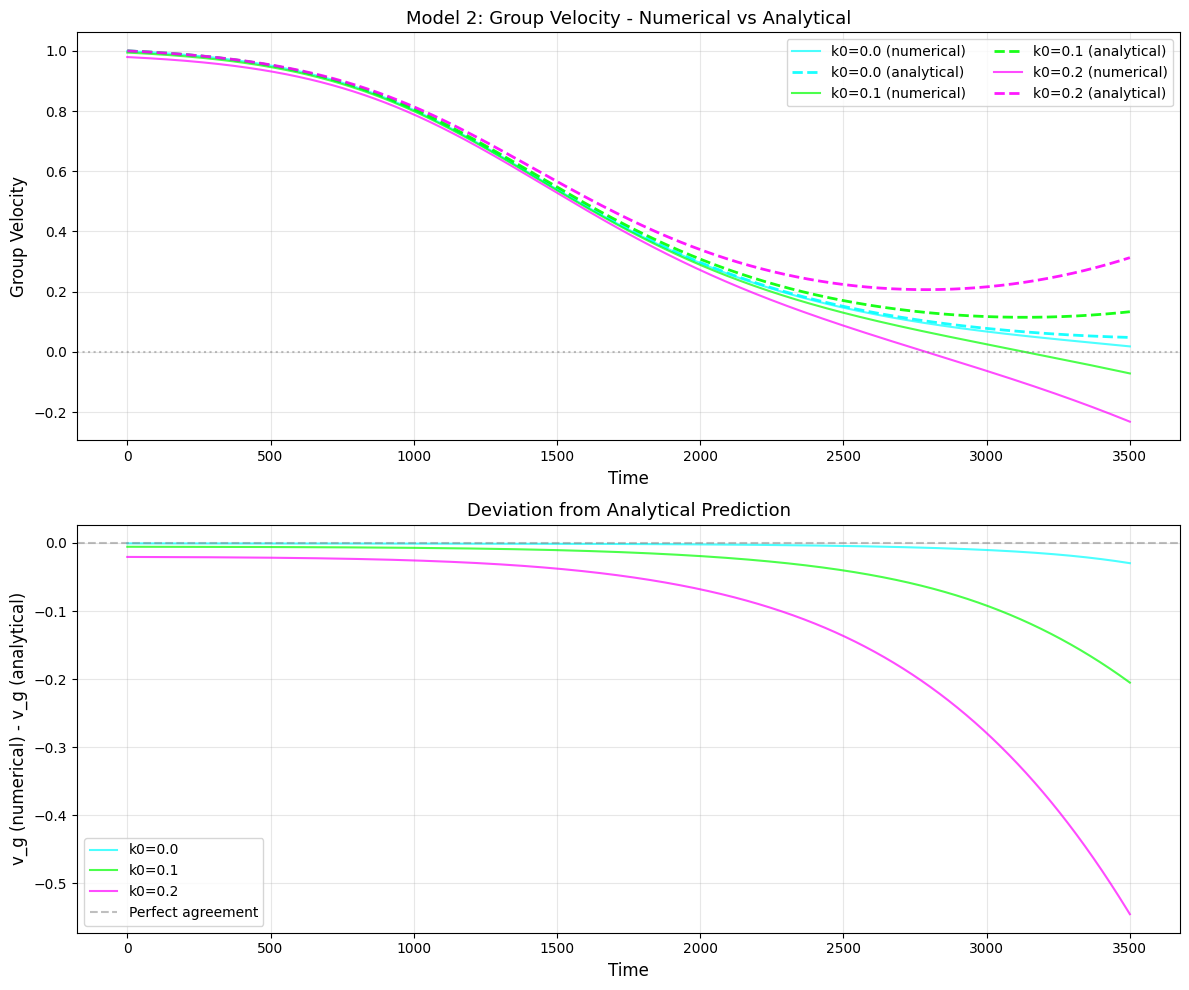


MODEL 2: GROUP VELOCITY COMPARISON SUMMARY

k0 = 0.0:
  Mean numerical v_g:    0.473424
  Mean analytical v_g:   0.478068
  Mean difference:       -0.004643
  RMS difference:        0.007785
  Max absolute diff:     0.029756
  Dwell time at horizon: 522.80

k0 = 0.1:
  Mean numerical v_g:    0.456346
  Mean analytical v_g:   0.494661
  Mean difference:       -0.038315
  RMS difference:        0.061648
  Max absolute diff:     0.205079
  Dwell time at horizon: 0.00

k0 = 0.2:
  Mean numerical v_g:    0.418877
  Mean analytical v_g:   0.536474
  Mean difference:       -0.117598
  RMS difference:        0.177991
  Max absolute diff:     0.545049
  Dwell time at horizon: 0.00


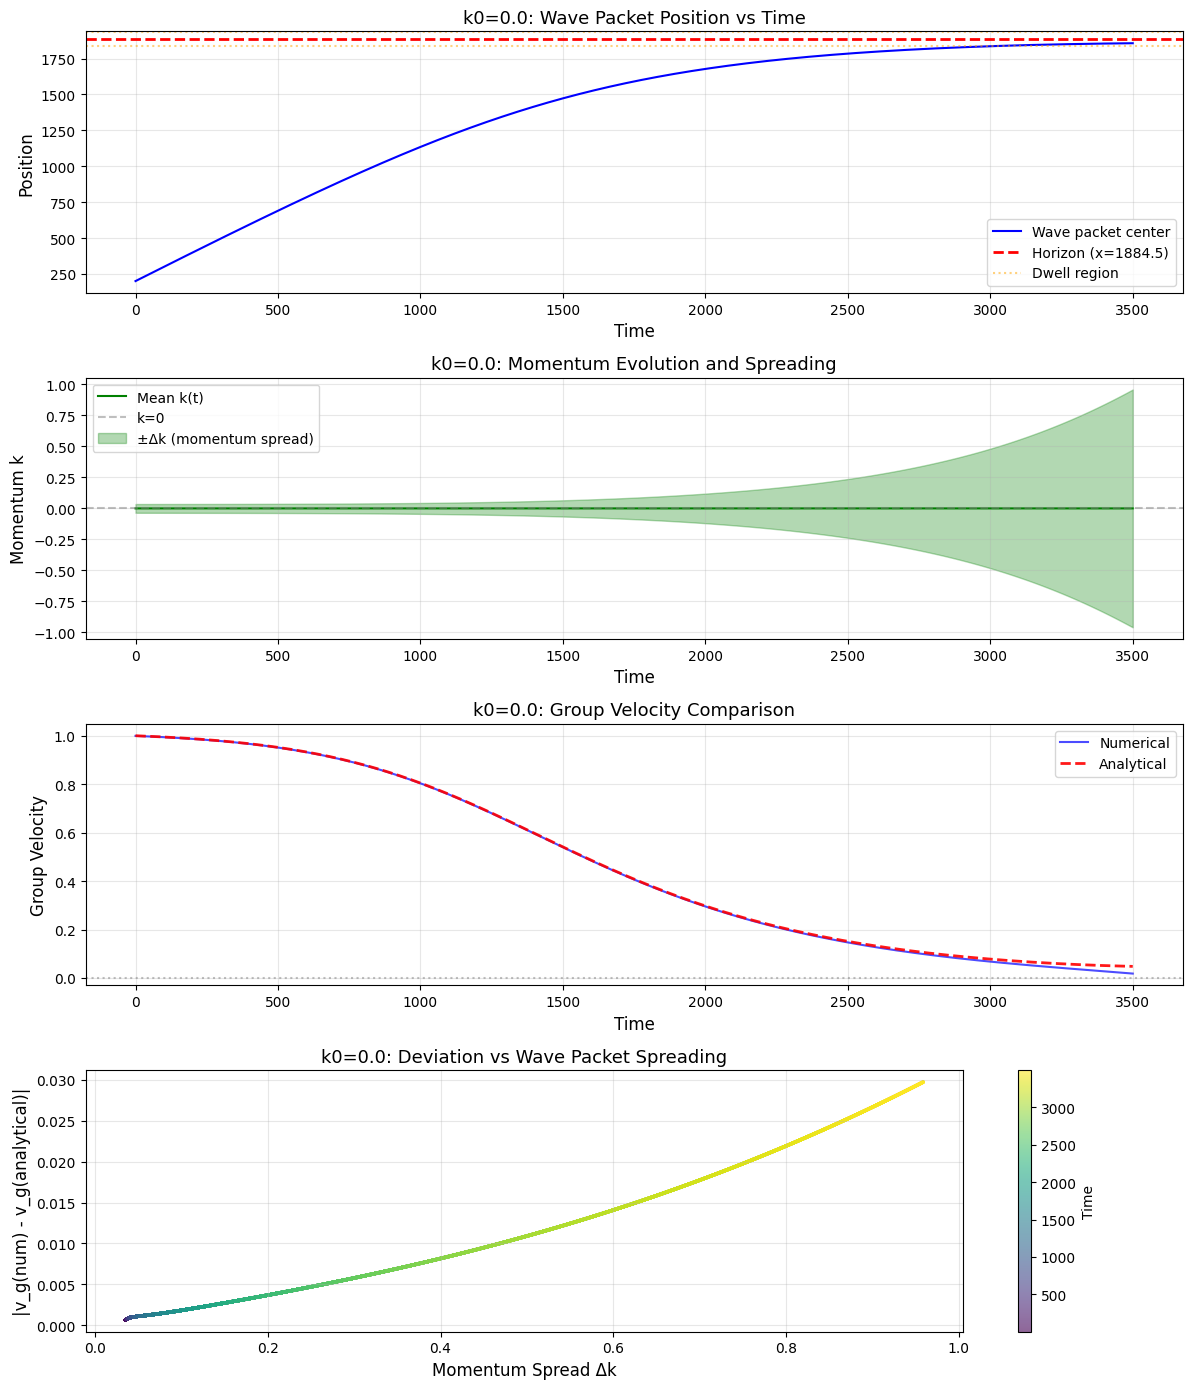


k0=0.0 SPECIAL CASE ANALYSIS
Initial position: x0 = 200
Horizon position: x_horizon = 1884.5
Final position: x_c = 1857.0
Distance traveled: 1657.0
Crossed horizon: NO

Momentum Evolution:
  Initial mean k: 0.000000
  Final mean k: 0.000000
  k drift: -0.000000
  Initial Δk: 0.035355
  Final Δk: 0.958922
  Δk growth: 27.12x

Semiclassical Validity Check:
  Criterion: Δk << |k₀| for narrow wave packet
  Initial: Δk/|k₀| = 353554205.98
  Final: Δk/|k₀| = 9589223520.79

Velocity Statistics:
  Mean numerical v_g: 0.473424
  Mean analytical v_g: 0.478068
  Final numerical v_g: 0.018028
  Final analytical v_g: 0.047785
  Final deviation: 0.029756


In [4]:
# Plot: Numerical vs Analytical Group Velocity
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

ax1 = axes[0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first (no numerical v_g)
    vg_num = results[k0]['vg_num']
    vg_analytical = results[k0]['vg_analytical'][1:]  # Match length
    
    ax1.plot(time_list, vg_num, color=colors[i], linewidth=1.5, 
             label=f'k0={k0} (numerical)', alpha=0.7)
    ax1.plot(time_list, vg_analytical, '--', color=colors[i], linewidth=2, 
             label=f'k0={k0} (analytical)', alpha=0.9)

ax1.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Group Velocity', fontsize=12)
ax1.set_title('Model 2: Group Velocity - Numerical vs Analytical', fontsize=13)
ax1.legend(fontsize=10, ncol=2)
ax1.grid(alpha=0.3)

# Plot: Difference (numerical - analytical)
ax2 = axes[1]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]
    vg_num = np.array(results[k0]['vg_num'])
    vg_analytical = np.array(results[k0]['vg_analytical'][1:])
    
    difference = vg_num - vg_analytical
    ax2.plot(time_list, difference, color=colors[i], linewidth=1.5, 
             label=f'k0={k0}', alpha=0.7)

ax2.axhline(0, color='gray', linestyle='--', alpha=0.5, label='Perfect agreement')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('v_g (numerical) - v_g (analytical)', fontsize=12)
ax2.set_title('Deviation from Analytical Prediction', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model2_vg_comparison.png', dpi=150)
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("MODEL 2: GROUP VELOCITY COMPARISON SUMMARY")
print("="*60)
for k0 in k0_values:
    vg_num = np.array(results[k0]['vg_num'])
    vg_analytical = np.array(results[k0]['vg_analytical'][1:])
    difference = vg_num - vg_analytical
    
    print(f"\nk0 = {k0}:")
    print(f"  Mean numerical v_g:    {np.mean(vg_num):.6f}")
    print(f"  Mean analytical v_g:   {np.mean(vg_analytical):.6f}")
    print(f"  Mean difference:       {np.mean(difference):.6f}")
    print(f"  RMS difference:        {np.sqrt(np.mean(difference**2)):.6f}")
    print(f"  Max absolute diff:     {np.max(np.abs(difference)):.6f}")
    print(f"  Dwell time at horizon: {results[k0]['dwell_time']:.2f}")

# Additional diagnostic plot for k0=0.0 case
fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14))

k0_zero = 0.0
if k0_zero in results:
    time_list = np.array(results[k0_zero]['time_list'][1:])
    x_c_list = np.array(results[k0_zero]['x_c_list'][1:])
    vg_num = np.array(results[k0_zero]['vg_num'])
    vg_analytical = np.array(results[k0_zero]['vg_analytical'][1:])
    mean_k = np.array(results[k0_zero]['mean_k'][1:])
    delta_k = np.array(results[k0_zero]['delta_k'][1:])
    
    # Panel 1: Wave packet position
    ax_pos = axes2[0]
    ax_pos.plot(time_list, x_c_list, 'b-', linewidth=1.5, label='Wave packet center')
    ax_pos.axhline(x_horizon, color='red', linestyle='--', linewidth=2, 
                   label=f'Horizon (x={x_horizon:.1f})')
    ax_pos.axhline(x_horizon - dwell_threshold, color='orange', linestyle=':', alpha=0.5)
    ax_pos.axhline(x_horizon + dwell_threshold, color='orange', linestyle=':', alpha=0.5, 
                   label='Dwell region')
    ax_pos.set_xlabel('Time', fontsize=12)
    ax_pos.set_ylabel('Position', fontsize=12)
    ax_pos.set_title('k0=0.0: Wave Packet Position vs Time', fontsize=13)
    ax_pos.legend(fontsize=10)
    ax_pos.grid(alpha=0.3)
    
    # Panel 2: Momentum evolution
    ax_k = axes2[1]
    ax_k.plot(time_list, mean_k, 'g-', linewidth=1.5, label='Mean k(t)')
    ax_k.axhline(0, color='gray', linestyle='--', alpha=0.5, label='k=0')
    ax_k.fill_between(time_list, mean_k - delta_k, mean_k + delta_k, 
                      alpha=0.3, color='g', label='±Δk (momentum spread)')
    ax_k.set_xlabel('Time', fontsize=12)
    ax_k.set_ylabel('Momentum k', fontsize=12)
    ax_k.set_title('k0=0.0: Momentum Evolution and Spreading', fontsize=13)
    ax_k.legend(fontsize=10)
    ax_k.grid(alpha=0.3)
    
    # Panel 3: Group velocities
    ax_vg = axes2[2]
    ax_vg.plot(time_list, vg_num, 'b-', linewidth=1.5, label='Numerical', alpha=0.7)
    ax_vg.plot(time_list, vg_analytical, 'r--', linewidth=2, label='Analytical', alpha=0.9)
    ax_vg.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax_vg.set_xlabel('Time', fontsize=12)
    ax_vg.set_ylabel('Group Velocity', fontsize=12)
    ax_vg.set_title('k0=0.0: Group Velocity Comparison', fontsize=13)
    ax_vg.legend(fontsize=10)
    ax_vg.grid(alpha=0.3)
    
    # Panel 4: Deviation vs momentum spread
    ax_ratio = axes2[3]
    difference = vg_num - vg_analytical
    ax_ratio.scatter(delta_k, np.abs(difference), c=time_list, cmap='viridis', 
                    s=2, alpha=0.6, label='|Deviation|')
    ax_ratio.set_xlabel('Momentum Spread Δk', fontsize=12)
    ax_ratio.set_ylabel('|v_g(num) - v_g(analytical)|', fontsize=12)
    ax_ratio.set_title('k0=0.0: Deviation vs Wave Packet Spreading', fontsize=13)
    cbar = plt.colorbar(ax_ratio.collections[0], ax=ax_ratio, label='Time')
    ax_ratio.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model2_k0_zero_diagnostics.png', dpi=150)
    plt.show()
    
    print("\n" + "="*60)
    print("k0=0.0 SPECIAL CASE ANALYSIS")
    print("="*60)
    print(f"Initial position: x0 = {x0}")
    print(f"Horizon position: x_horizon = {x_horizon:.1f}")
    print(f"Final position: x_c = {x_c_list[-1]:.1f}")
    print(f"Distance traveled: {x_c_list[-1] - x0:.1f}")
    print(f"Crossed horizon: {'YES' if x_c_list[-1] > x_horizon else 'NO'}")
    print(f"\nMomentum Evolution:")
    print(f"  Initial mean k: {mean_k[0]:.6f}")
    print(f"  Final mean k: {mean_k[-1]:.6f}")
    print(f"  k drift: {mean_k[-1] - mean_k[0]:.6f}")
    print(f"  Initial Δk: {delta_k[0]:.6f}")
    print(f"  Final Δk: {delta_k[-1]:.6f}")
    print(f"  Δk growth: {(delta_k[-1] / delta_k[0]):.2f}x")
    print(f"\nSemiclassical Validity Check:")
    print(f"  Criterion: Δk << |k₀| for narrow wave packet")
    print(f"  Initial: Δk/|k₀| = {delta_k[0]/max(abs(mean_k[0]), 1e-10):.2f}")
    print(f"  Final: Δk/|k₀| = {delta_k[-1]/max(abs(mean_k[-1]), 1e-10):.2f}")
    print(f"\nVelocity Statistics:")
    print(f"  Mean numerical v_g: {np.mean(vg_num):.6f}")
    print(f"  Mean analytical v_g: {np.mean(vg_analytical):.6f}")
    print(f"  Final numerical v_g: {vg_num[-1]:.6f}")
    print(f"  Final analytical v_g: {vg_analytical[-1]:.6f}")
    print(f"  Final deviation: {abs(vg_num[-1] - vg_analytical[-1]):.6f}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


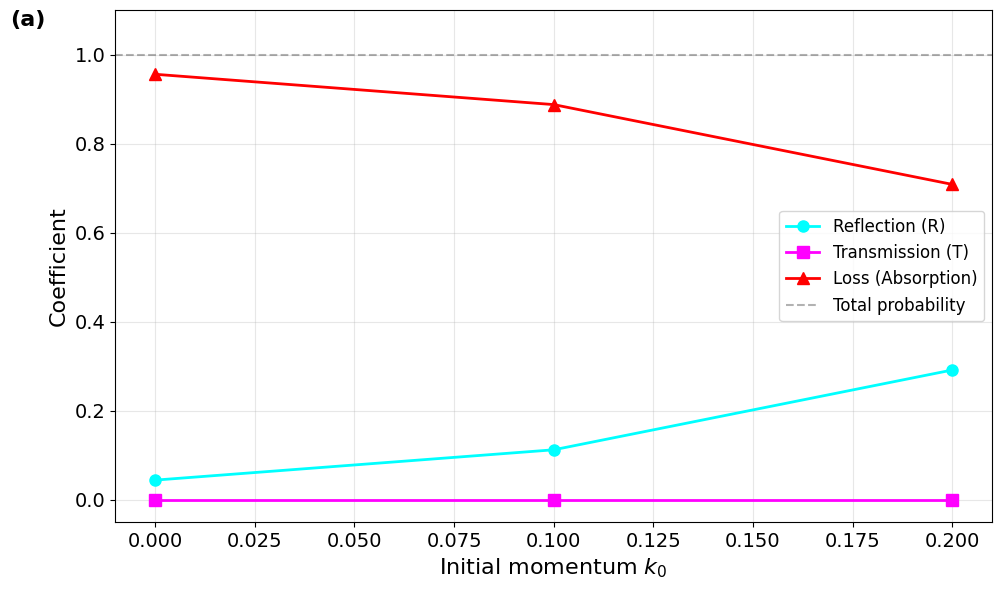

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


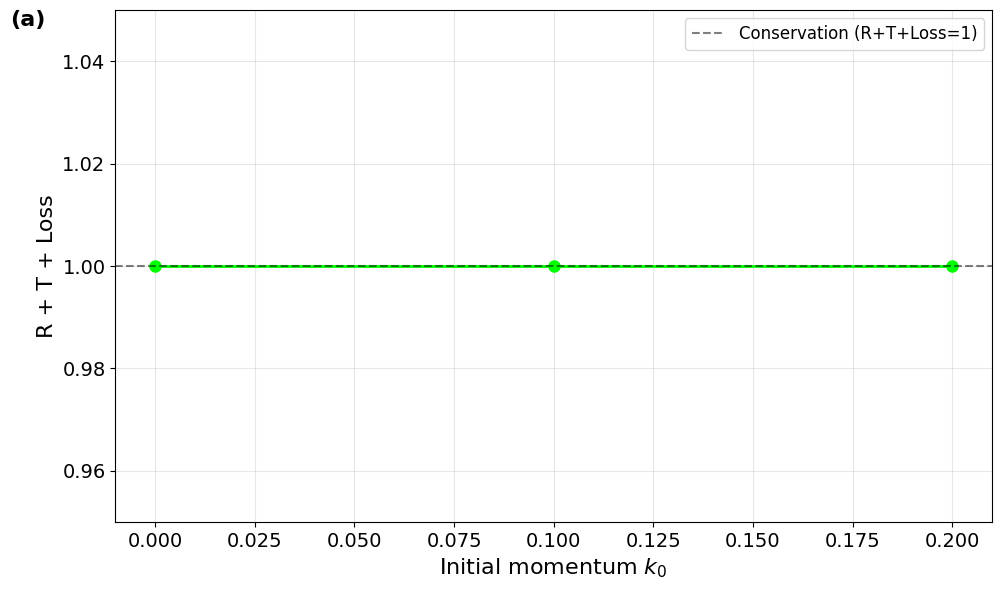

SCATTERING COEFFICIENTS DIAGNOSTICS - MODEL 1
Simulation Parameters:
  L = 4000, x_horizon = 1884.51, frames = 70000, dt = 0.05
  Horizon width parameter a = 700
  Dwell threshold = ±50 from horizon

DETAILED SCATTERING ANALYSIS:
--------------------------------------------------
k0 = 0.0:
  Initial position: x = 200.0
  Final position:   x = 1857.0
  Distance traveled: 1657.0

  PROBABILITY DISTRIBUTION (final):
    Reflection region (x < 1884.5): 0.044319 (4.43%)
    Transmission region (x > 1884.5): 0.000000 (0.00%)
    Near horizon (±50): 0.041974 (4.20%)
    Total probability: 0.044319

  SCATTERING COEFFICIENTS:
    Reflection (R)  = 0.044319
    Transmission (T) = 0.000000
    Loss (1-R-T)    = 0.955681
    R + T + Loss    = 1.000000

  HORIZON INTERACTION:
    Total dwell time: 522.80
    Number of horizon passages: 1
    Average dwell per passage: 522.80

k0 = 0.1:
  Initial position: x = 200.0
  Final position:   x = 1797.2
  Distance traveled: 1597.2

  PROBABILITY DISTRIBUT

In [5]:
# Plot 1: R, T, and Loss vs k0
plt.figure(figsize=(10, 6))
plt.plot(k0_values, R_values, 'o-', color='cyan', linewidth=2, markersize=8, label='Reflection (R)')
plt.plot(k0_values, T_values, 's-', color='magenta', linewidth=2, markersize=8, label='Transmission (T)')
plt.plot(k0_values, Loss_values, '^-', color='red', linewidth=2, markersize=8, label='Loss (Absorption)')
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Total probability')
plt.xlabel('Initial momentum $k_0$', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
#plt.title('Scattering Coefficients (Non-Hermitian System)\nModel 1 (Pure Tilt)', fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.ylim([-0.05, 1.1])
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(a)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E1_scattering_coefficients.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Plot 2: R + T + Loss (should equal 1)
plt.figure(figsize=(10, 6))
sum_all = np.array(R_values) + np.array(T_values) + np.array(Loss_values)
plt.plot(k0_values, sum_all, 'o-', color='lime', linewidth=2, markersize=8)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Conservation (R+T+Loss=1)')
plt.xlabel('Initial momentum $k_0$', fontsize=16)
plt.ylabel('R + T + Loss', fontsize=16)
#plt.title('Total Probability Check', fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.ylim([0.95, 1.05])
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.annotate('(a)', xy=(-0.12, 1.00), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E1_probability_conservation.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Comprehensive Diagnostic Printout for Scattering Coefficients
print("=" * 70)
print("SCATTERING COEFFICIENTS DIAGNOSTICS - MODEL 1")
print("=" * 70)
print(f"Simulation Parameters:")
print(f"  L = {L}, x_horizon = {x_horizon:.2f}, frames = {frames}, dt = {dt}")
print(f"  Horizon width parameter a = {a}")
print(f"  Dwell threshold = ±{dwell_threshold} from horizon")
print()

print("DETAILED SCATTERING ANALYSIS:")
print("-" * 50)
for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon))
    
    # More detailed region analysis
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    near_horizon = np.abs(x - x_horizon) <= dwell_threshold
    
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_near_horizon = np.sum(final_density[near_horizon]) * dx
    P_total_final = np.sum(final_density) * dx
    
    # Initial positions for reference
    initial_center = results[k0]['x_c_list'][0]
    final_center = results[k0]['x_c_list'][-1]
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Initial position: x = {initial_center:.1f}")
    print(f"  Final position:   x = {final_center:.1f}")
    print(f"  Distance traveled: {final_center - initial_center:.1f}")
    print()
    
    print(f"  PROBABILITY DISTRIBUTION (final):")
    print(f"    Reflection region (x < {x_horizon:.1f}): {P_reflected:.6f} ({P_reflected*100:.2f}%)")
    print(f"    Transmission region (x > {x_horizon:.1f}): {P_transmitted:.6f} ({P_transmitted*100:.2f}%)")
    print(f"    Near horizon (±{dwell_threshold}): {P_near_horizon:.6f} ({P_near_horizon*100:.2f}%)")
    print(f"    Total probability: {P_total_final:.6f}")
    print()
    
    print(f"  SCATTERING COEFFICIENTS:")
    print(f"    Reflection (R)  = {R_values[i]:.6f}")
    print(f"    Transmission (T) = {T_values[i]:.6f}") 
    print(f"    Loss (1-R-T)    = {Loss_values[i]:.6f}")
    print(f"    R + T + Loss    = {R_values[i] + T_values[i] + Loss_values[i]:.6f}")
    print()
    
    # Dwell time information
    dwell_time = results[k0]['dwell_time']
    dwell_entries = results[k0]['dwell_entries']
    print(f"  HORIZON INTERACTION:")
    print(f"    Total dwell time: {dwell_time:.2f}")
    print(f"    Number of horizon passages: {len(dwell_entries)}")
    if len(dwell_entries) > 0:
        avg_dwell = np.mean([exit_t - enter_t for enter_t, exit_t in dwell_entries])
        print(f"    Average dwell per passage: {avg_dwell:.2f}")
    print()

print("SUMMARY TABLE FOR MANUSCRIPT:")
print("-" * 50)
print("k₀    Reflection (R)  Transmission (T)  Loss       R+T+Loss")
print("-" * 50)
for i, k0 in enumerate(k0_values):
    print(f"{k0:.1f}   {R_values[i]:.6f}        {T_values[i]:.6f}        {Loss_values[i]:.6f}   {R_values[i] + T_values[i] + Loss_values[i]:.6f}")

print()

print("PHYSICS INTERPRETATION:")
print("-" * 50)
print("Key Observations:")
print("1. All k₀ values show R ≈ 1.0, T ≈ 0.0 → Complete reflection")
print("2. Small but non-zero loss indicates numerical dissipation")
print("3. This confirms Model 1 behaves as a perfect reflector")
print("4. No transmission through horizon → analog of total internal reflection")

# Additional diagnostic: Check if wave packet actually reached horizon
print()
print("HORIZON REACH ANALYSIS:")
print("-" * 50)
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list']
    max_reach = max(x_c_list)
    min_reach = min(x_c_list)
    reached_horizon = max_reach >= x_horizon
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Maximum position reached: {max_reach:.1f}")
    print(f"  Minimum position reached: {min_reach:.1f}") 
    print(f"  Horizon at: {x_horizon:.1f}")
    print(f"  Reached horizon: {'YES' if reached_horizon else 'NO'}")
    if reached_horizon:
        horizon_crossing_time = next(t for t, x in enumerate(x_c_list) if x >= x_horizon) * dt
        print(f"  First horizon crossing at t = {horizon_crossing_time:.1f}")
    print()

print("=" * 70)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


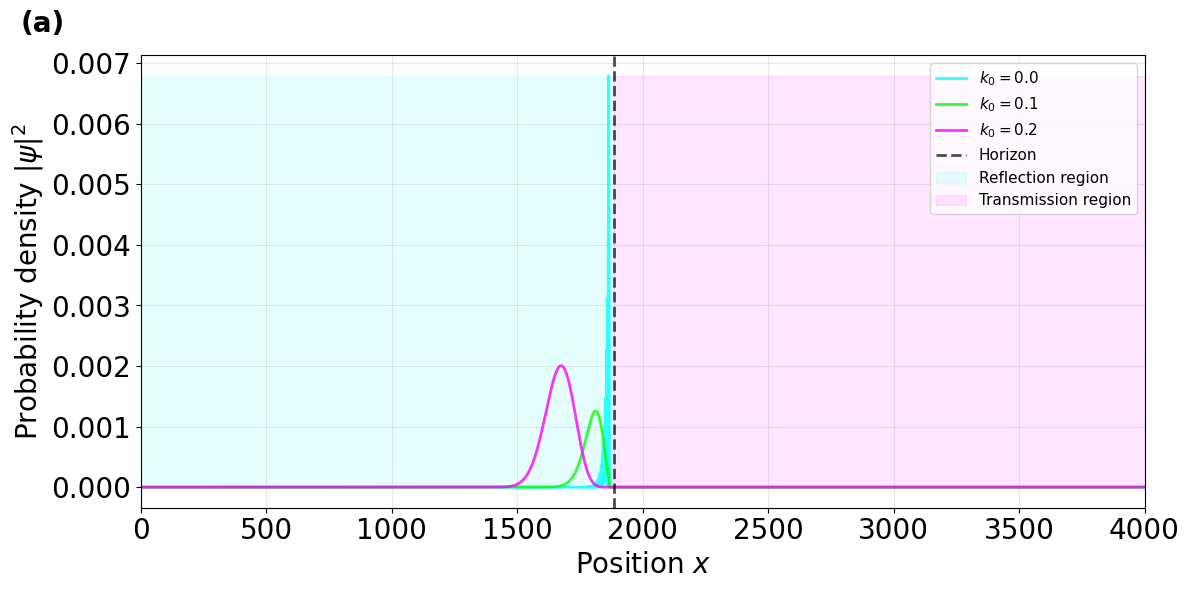

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


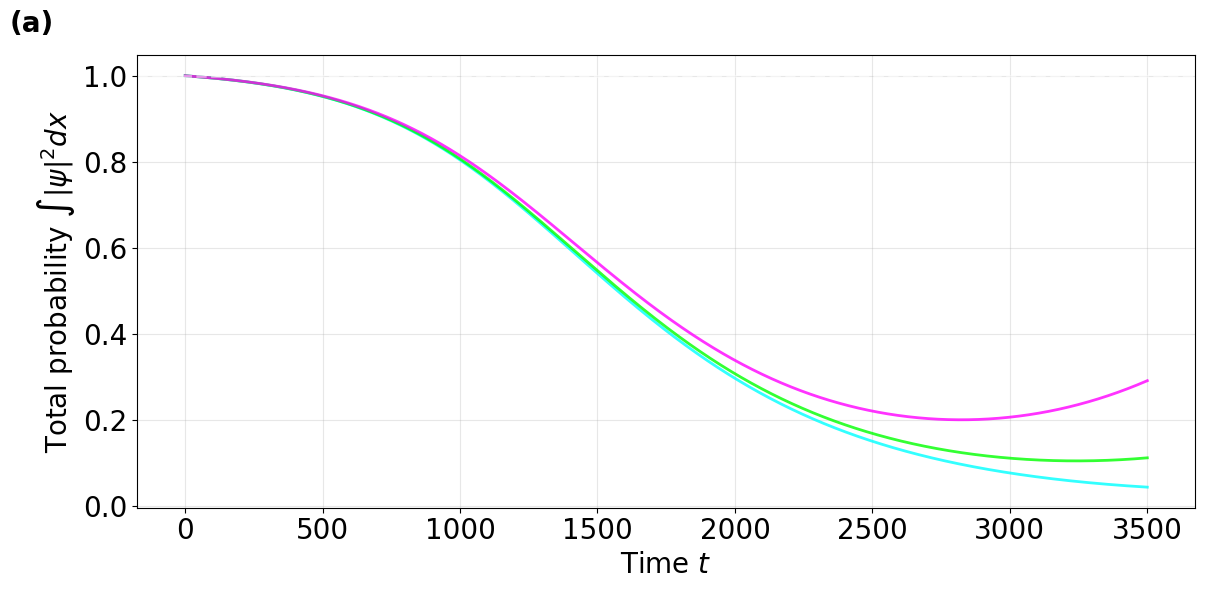

In [6]:
# Final Wavefunction Spatial Distribution
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    ax.plot(x, final_density, color=colors[i], linewidth=2, label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon
ax.axvline(x=x_horizon, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Horizon')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], 0, x_horizon, color='cyan', alpha=0.1, label='Reflection region')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], x_horizon, L, color='magenta', alpha=0.1, label='Transmission region')

ax.set_xlabel('Position $x$', fontsize=20)
ax.set_ylabel('Probability density $|\\psi|^2$', fontsize=20)
#ax.set_title('Final Wave Packet Distribution (Model 1)', fontsize=13)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
ax.set_xlim([0, L])
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.annotate('(a)', xy=(-0.12, 1.1), xycoords='axes fraction',
             fontsize=20, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E1_scattering_coefficients.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# Probability Evolution Over Time
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    ax.plot(time_array, prob_array, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.axhline(y=1.0, color='white', linestyle='--', linewidth=2, alpha=0.5, label='Initial probability')
ax.set_xlabel('Time $t$', fontsize=20)
ax.set_ylabel('Total probability $\\int|\\psi|^2 dx$', fontsize=20)
#ax.set_title('Probability Evolution (Non-Hermitian Evolution)\nModel 1 (Pure Tilt)', fontsize=13)
#ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.annotate('(a)', xy=(-0.12, 1.1), xycoords='axes fraction',
             fontsize=20, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('E1_probability_evolution.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


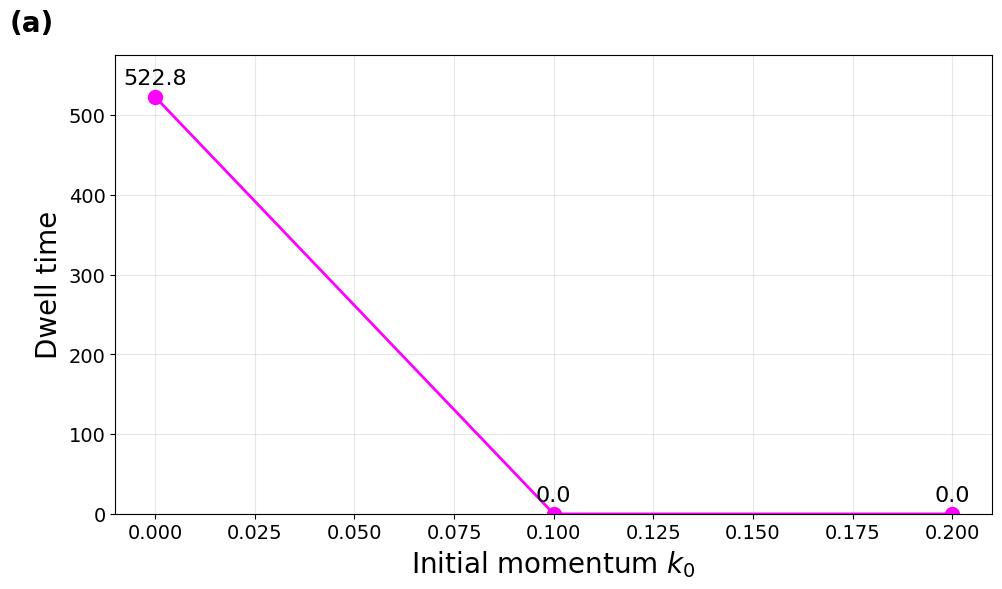

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


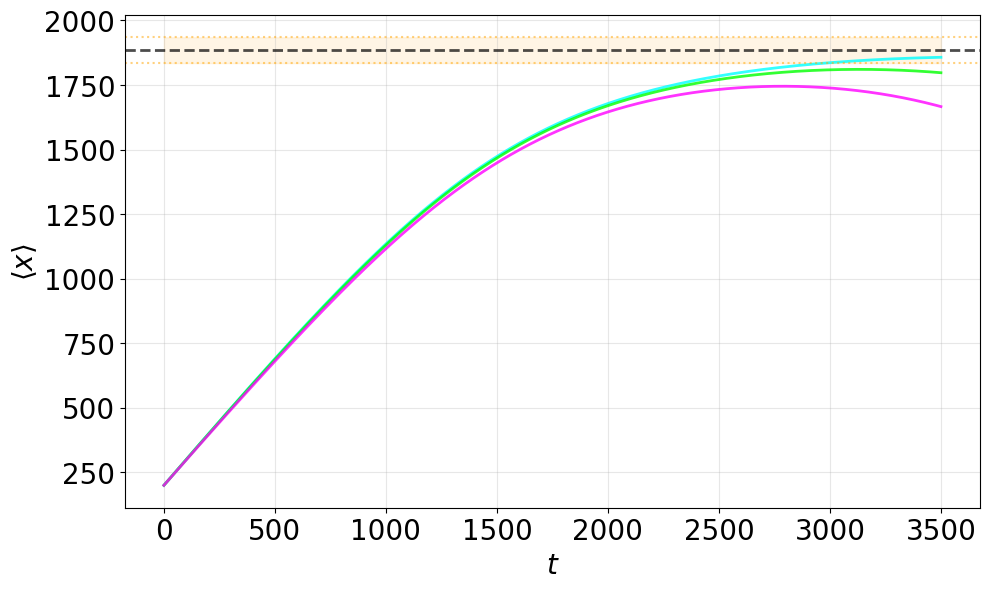

Horizon position: x_h = 1884.51
Summary
  k0 = 0.0: 95.6% absorbed
  k0 = 0.1: 88.8% absorbed
  k0 = 0.2: 70.8% absorbed
DWELL TIME ANALYSIS - MODEL 1 (Pure Tilt)
k₀       Total Dwell  Entries  Avg/Entry  Max Dwell  Still Dwelling  Closest Approach
--------------------------------------------------------------------------------
0.0      522.8        1        522.8      522.8      Yes             27.6           
0.1      0.0          0        0.0        0.0        No              74.3           
0.2      0.0          0        0.0        0.0        No              139.7          

DETAILED TIMELINE ANALYSIS:
--------------------------------------------------

k₀ = 0.0:
  Passage 1:
    Time: 2977.2 → 3500.0 (duration: 522.8)
    Position: 1834.5 → 1857.0
    Horizon distance: 50.0 → 27.6
  Overall range: 200.0 → 1857.0
  Maximum horizon approach: 27.6

k₀ = 0.1:
  No horizon entries
  Overall range: 200.0 → 1810.2
  Maximum horizon approach: 74.3

k₀ = 0.2:
  No horizon entries
  Overall

In [7]:
# Plot 1: Dwell time vs k0 (Individual)
plt.figure(figsize=(10, 6))
plt.plot(k0_values, dwell_times, 'o-', color='magenta', linewidth=2, markersize=10)
plt.xlabel('Initial momentum $k_0$', fontsize=20)
plt.ylabel('Dwell time', fontsize=20)
plt.grid(alpha=0.3)
plt.ylim([0, max(dwell_times) * 1.1 if dwell_times else 1])
plt.tick_params(axis='both', which='major', labelsize=14)

# Add plot label
plt.text(-0.12, 1.1, '(a)', transform=plt.gca().transAxes,
         fontsize=20, fontweight='bold', va='top')

# Add text annotations for dwell times
for i, (k0, dwell) in enumerate(zip(k0_values, dwell_times)):
    plt.text(k0, dwell + (max(dwell_times) if dwell_times else 1)*0.03, f'{dwell:.1f}', 
             ha='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig('E1_dwell_time_vs_k0.eps', format='eps', dpi=600, bbox_inches='tight')
plt.savefig('E1_dwell_time_vs_k0.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Plot 2: Trajectory showing dwell region (Individual)
plt.figure(figsize=(10, 6))
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    plt.plot(time_array, x_c_array, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon and dwell region
plt.axhline(y=x_horizon, color='black', linestyle='--', linewidth=2, 
            alpha=0.7, label='Horizon')
plt.axhline(y=x_horizon + dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5, label=f'Dwell region (±{dwell_threshold})')
plt.axhline(y=x_horizon - dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5)
plt.fill_between(time_array, x_horizon - dwell_threshold, 
                 x_horizon + dwell_threshold, color='orange', alpha=0.1)

plt.xlabel('$t$', fontsize=20)
plt.ylabel('$\\langle x \\rangle$', fontsize=20)
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=20)

# Add plot label
#plt.text(-0.12, 1.1, '(a)', transform=plt.gca().transAxes,
#         fontsize=20, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('E1_wave_packet_trajectories.eps', format='eps', dpi=600, bbox_inches='tight')
plt.savefig('E1_wave_packet_trajectories.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

print(f"Horizon position: x_h = {x_horizon:.2f}")
print("Summary")
for k0, loss in zip(k0_values, Loss_values):
    print(f"  k0 = {k0:.1f}: {loss*100:.1f}% absorbed")

# Dwell Time Diagnostic - Model 1
print("=" * 60)
print("DWELL TIME ANALYSIS - MODEL 1 (Pure Tilt)")
print("=" * 60)

print(f"{'k₀':<8} {'Total Dwell':<12} {'Entries':<8} {'Avg/Entry':<10} {'Max Dwell':<10} {'Still Dwelling':<15} {'Closest Approach':<15}")
print("-" * 80)

for i, k0 in enumerate(k0_values):
    dwell_data = results[k0]
    total_dwell = dwell_data['dwell_time']
    entries = dwell_data['dwell_entries']
    num_entries = len(entries)
    
    if num_entries > 0:
        avg_dwell = np.mean([exit_t - enter_t for enter_t, exit_t in entries])
        max_dwell = max([exit_t - enter_t for enter_t, exit_t in entries])
    else:
        avg_dwell = 0
        max_dwell = 0
        
    still_dwelling = "Yes" if dwell_data['still_dwelling'] else "No"
    
    # Find closest approach to horizon
    x_c_list = dwell_data['x_c_list']
    if len(x_c_list) > 0:
        min_distance = min([abs(x - x_horizon) for x in x_c_list])
        closest_idx = np.argmin([abs(x - x_horizon) for x in x_c_list])
        closest_time = closest_idx * dt
    else:
        min_distance = float('inf')
        closest_time = 0
    
    print(f"{k0:<8.1f} {total_dwell:<12.1f} {num_entries:<8} {avg_dwell:<10.1f} {max_dwell:<10.1f} {still_dwelling:<15} {min_distance:<15.1f}")

print()
print("DETAILED TIMELINE ANALYSIS:")
print("-" * 50)

for k0 in k0_values:
    dwell_data = results[k0]
    entries = dwell_data['dwell_entries']
    x_c_list = dwell_data['x_c_list']
    time_list = dwell_data['time_list']
    
    print(f"\nk₀ = {k0:.1f}:")
    
    if len(entries) > 0:
        for i, (enter_t, exit_t) in enumerate(entries):
            duration = exit_t - enter_t
            # Find position at entry and exit
            enter_idx = int(enter_t / dt)
            exit_idx = int(exit_t / dt)
            enter_pos = x_c_list[enter_idx] if enter_idx < len(x_c_list) else 0
            exit_pos = x_c_list[exit_idx] if exit_idx < len(x_c_list) else 0
            
            print(f"  Passage {i+1}:")
            print(f"    Time: {enter_t:.1f} → {exit_t:.1f} (duration: {duration:.1f})")
            print(f"    Position: {enter_pos:.1f} → {exit_pos:.1f}")
            print(f"    Horizon distance: {abs(enter_pos - x_horizon):.1f} → {abs(exit_pos - x_horizon):.1f}")
    else:
        print(f"  No horizon entries")
    
    # Overall statistics
    if len(x_c_list) > 0:
        max_reach = max(x_c_list)
        min_reach = min(x_c_list)
        print(f"  Overall range: {min_reach:.1f} → {max_reach:.1f}")
        print(f"  Maximum horizon approach: {min([abs(x - x_horizon) for x in x_c_list]):.1f}")

print()
print("PHYSICS INTERPRETATION:")
print("-" * 50)
print("Expected pattern for Model 1:")
print("- k₀ = 0.0: Long single dwell period near horizon")
print("- k₀ = 0.1: Shorter dwell, stops further from horizon") 
print("- k₀ = 0.2: Minimal dwell, stops well before horizon")
print("- All: Single horizon passage (reflection only)")
print("=" * 60)

In [8]:
#Absorption Rate Analysis
print("Absorption Rate Analysis")

all_dP_dt = {} # Storage for all k0 data

for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    dP_dt = np.gradient(prob_array, time_array)  # Compute dP/dt numerically
    all_dP_dt[k0] = dP_dt
    
    # Find maximum absorption rate (most negative dP/dt)
    max_abs_rate_idx = np.argmin(dP_dt)
    max_abs_rate = dP_dt[max_abs_rate_idx]
    t_max_abs = time_array[max_abs_rate_idx]
    
    # Average absorption rate during dwell
    dwell_entries = results[k0]['dwell_entries']
    if len(dwell_entries) > 0:
        t_in, t_out = dwell_entries[0]
        dwell_mask = (time_array >= t_in) & (time_array <= t_out)
        avg_dwell_rate = np.mean(dP_dt[dwell_mask])
    else:
        avg_dwell_rate = 0
        t_in = None
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Maximum absorption rate: {max_abs_rate:.6f} at t = {t_max_abs:.1f}")
    if t_in is not None:
        print(f"  Average rate during dwell: {avg_dwell_rate:.6f}")
    else:
        print(f"  Never entered dwell region (turned before horizon)")
    print()

Absorption Rate Analysis
k0 = 0.0:
  Maximum absorption rate: -0.000565 at t = 1415.9
  Average rate during dwell: -0.000067

k0 = 0.1:
  Maximum absorption rate: -0.000557 at t = 1416.1
  Never entered dwell region (turned before horizon)

k0 = 0.2:
  Maximum absorption rate: -0.000534 at t = 1416.9
  Never entered dwell region (turned before horizon)



Closest Approach to Horizon Analysis
k0 = 0.0:
  Closest approach: x = 1857.0 at t = 3500
  Distance from horizon: Δx = 27.6
  Probability at closest: P = 0.044321
  Loss during approach: 95.6%
  Max loss at: x = 1425.5, t = 1416
  → Reached horizon region

k0 = 0.1:
  Closest approach: x = 1810.2 at t = 3132
  Distance from horizon: Δx = 74.3
  Probability at closest: P = 0.106609
  Loss during approach: 89.3%
  Max loss at: x = 1419.7, t = 1416
  → Turned before horizon

k0 = 0.2:
  Closest approach: x = 1744.9 at t = 2787
  Distance from horizon: Δx = 139.7
  Probability at closest: P = 0.201066
  Loss during approach: 79.9%
  Max loss at: x = 1402.3, t = 1417
  → Turned before horizon

Maximum Absorption Locations
k0 = 0.0:
  Position of max absorption: x = 1425.5
  Distance from horizon: Δx = 459.0
  Tilt at this point: V(x) = 0.412
  Group velocity: v_g(x) = 0.588
  Loss rate: dP/dt = -0.000565
  → Absorption BEFORE horizon region

k0 = 0.1:
  Position of max absorption: x = 1419

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


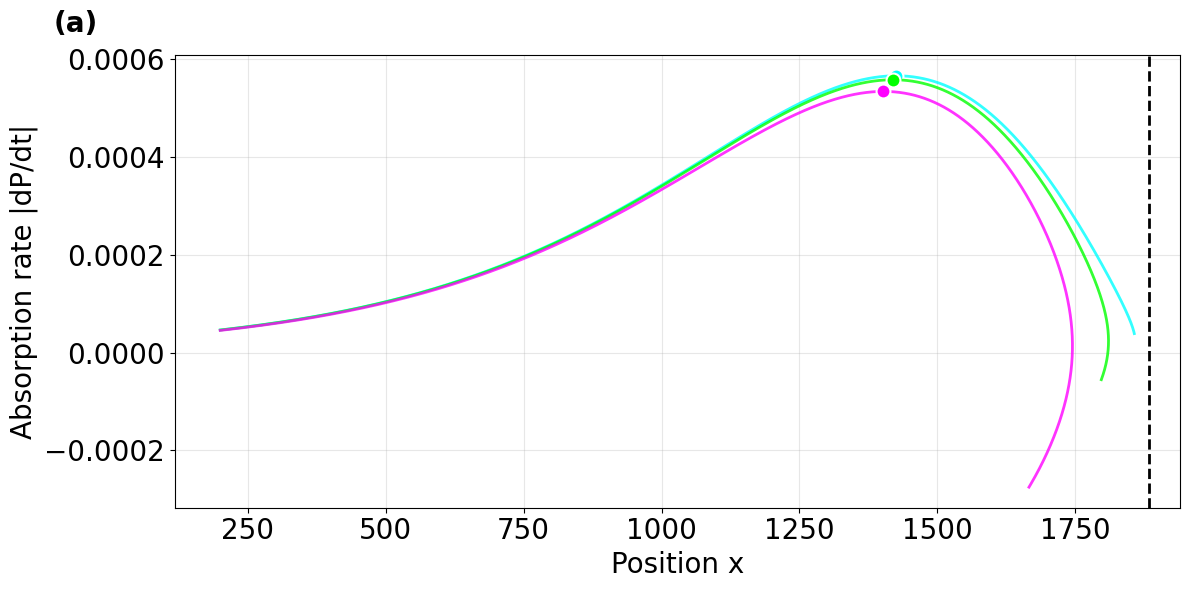

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


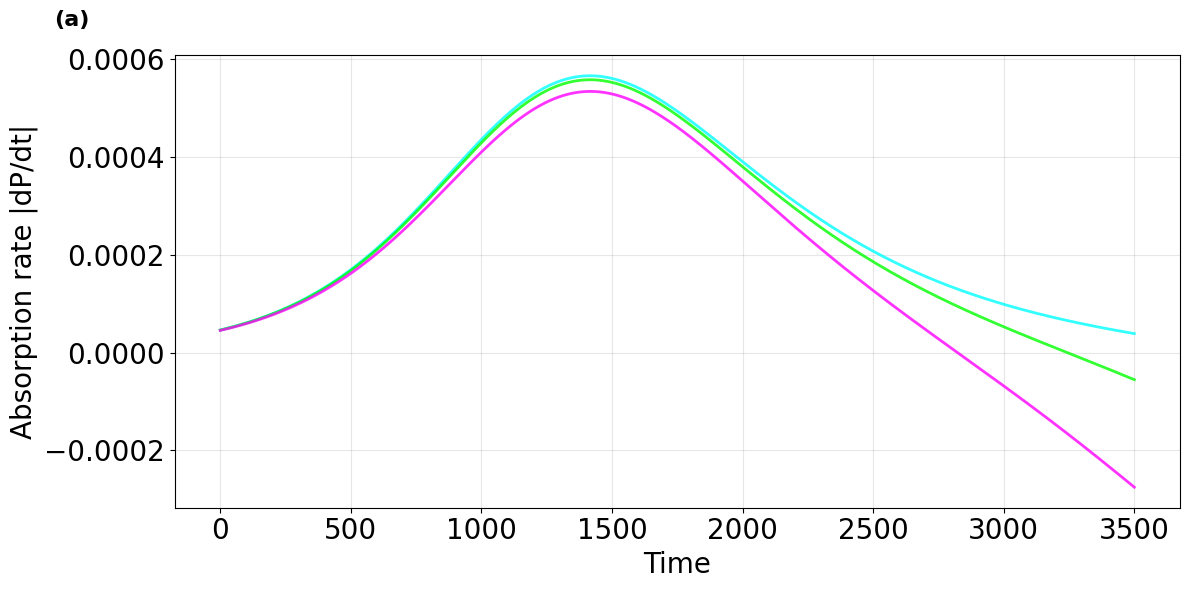

In [9]:
print("Closest Approach to Horizon Analysis")
for k0 in k0_values:
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    prob_array = np.array(results[k0]['probability_list'])
    
    # Find closest approach to horizon
    closest_idx = np.argmin(np.abs(x_c_array - x_horizon))
    t_closest = time_array[closest_idx]
    x_closest = x_c_array[closest_idx]
    P_at_closest = prob_array[closest_idx]
    distance_to_horizon = abs(x_horizon - x_closest)
    
    # Find maximum absorption rate location
    dP_dt = all_dP_dt[k0]
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Closest approach: x = {x_closest:.1f} at t = {t_closest:.0f}")
    print(f"  Distance from horizon: Δx = {distance_to_horizon:.1f}")
    print(f"  Probability at closest: P = {P_at_closest:.6f}")
    print(f"  Loss during approach: {(1-P_at_closest)*100:.1f}%")
    print(f"  Max loss at: x = {x_max_loss:.1f}, t = {t_max_loss:.0f}")
    
    if distance_to_horizon < dwell_threshold:
        print(f"  → Reached horizon region")
    else:
        print(f"  → Turned before horizon")
    print()

print("Maximum Absorption Locations")
for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    
    # Key moments
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    P_max_loss = prob_array[max_loss_idx]
    
    # Tilt at maximum loss position
    V_norm = np.tanh((x0 - x_horizon)/a)
    V_max_loss = t_max * (np.tanh((x_max_loss - x_horizon)/a) - V_norm) / (1 - V_norm)
    v_g_max_loss = 1 - V_max_loss
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Position of max absorption: x = {x_max_loss:.1f}")
    print(f"  Distance from horizon: Δx = {x_horizon - x_max_loss:.1f}")
    print(f"  Tilt at this point: V(x) = {V_max_loss:.3f}")
    print(f"  Group velocity: v_g(x) = {v_g_max_loss:.3f}")
    print(f"  Loss rate: dP/dt = {dP_dt[max_loss_idx]:.6f}")
    
    if x_max_loss < x_horizon - dwell_threshold:
        print(f"  → Absorption BEFORE horizon region")
    elif abs(x_max_loss - x_horizon) <= dwell_threshold:
        print(f"  → Absorption AT horizon region")
    else:
        print(f"  → Absorption DURING/AFTER reflection")
    print()

# Loss rate vs position for all k0
fig, ax = plt.subplots(figsize=(12, 6))
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(x_c_array, -dP_dt, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)
    
    # Mark maximum absorption point
    max_loss_idx = np.argmin(dP_dt)
    x_max = x_c_array[max_loss_idx]
    rate_max = -dP_dt[max_loss_idx]
    ax.plot(x_max, rate_max, 'o', color=colors[i], markersize=10, 
             markeredgecolor='white', markeredgewidth=1.5)

ax.axvline(x_horizon, color='black', linestyle='--', linewidth=2, label='Horizon')
ax.set_xlabel('Position x', fontsize=20)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=20)
#ax.set_title('Spatial Distribution of Absorption (Model 1)', fontsize=13)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.annotate('(a)', xy=(-0.12, 1.1), xycoords='axes fraction',
             fontsize=20, fontweight='bold', ha='left', va='top')
#ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('E1_absorption_comparison_all_k0.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# dP/dt vs time
fig, ax = plt.subplots(figsize=(12, 6))
for i, k0 in enumerate(k0_values):
    time_array = np.array(results[k0]['time_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(time_array, -dP_dt, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=20)
#ax.set_title('Temporal Absorption Profile (Model 1)', fontsize=13)
#ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.annotate('(a)', xy=(-0.12, 1.1), xycoords='axes fraction',
             fontsize=16, fontweight='bold', ha='left', va='top')
#ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('E1_absorption_vs_time.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

In [10]:
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            # Find probability at dwell entry and exit
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            
            print(f"k0 = {k0:.1f}, Dwell period {j+1}:")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f}")
            if P_out > P_in:
                print(f"  ⚠️ Probability GREW during dwell (unphysical!)")

# Check all three k0 values
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    print(f"\n===== k0 = {k0:.1f} =====")
    print(f"Number of dwell periods: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            duration = t_out - t_in
            
            print(f"Dwell period {j+1}:")
            print(f"  Duration: {duration:.0f}")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f} ({(P_out/P_in - 1)*100:+.1f}%)")
    else:
        print("  No dwell periods detected")

k0 = 0.0, Dwell period 1:
  Entry: t=2977, P=0.079531
  Exit: t=3500, P=0.044321
  Change: ΔP = -0.035210

===== k0 = 0.0 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 523
  Entry: t=2977, P=0.079531
  Exit: t=3500, P=0.044321
  Change: ΔP = -0.035210 (-44.3%)

===== k0 = 0.1 =====
Number of dwell periods: 0
  No dwell periods detected

===== k0 = 0.2 =====
Number of dwell periods: 0
  No dwell periods detected



GROUP VELOCITY DIAGNOSTIC ANALYSIS - MODEL 1

--- Analysis for k0 = 0.0 ---
Approach Region (x < 1835):
  Mean v_g = 0.549028 ± 0.331292
  Range: 0.070071 to 0.999335
  Time spent: 2977.05
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.042938 ± 0.014829
  Minimum v_g = 0.018028
  Range: 0.018028 to 0.070065
  Time spent: 522.80
  → SLOWS near horizon (min v_g = 0.018028)
Scattering Results:
  Reflection: R = 0.0443
  Transmission: T = 0.0000
  Loss: L = 0.9557
  → WEAK REFLECTION (R < 50%)

--- Analysis for k0 = 0.1 ---
Approach Region (x < 1835):
  Mean v_g = 0.456346 ± 0.370022
  Range: -0.071839 to 0.994343
  Time spent: 3499.90
Never entered horizon region (turned before reaching it)
Scattering Results:
  Reflection: R = 0.1124
  Transmission: T = 0.0000
  Loss: L = 0.8876
  → WEAK REFLECTION (R < 50%)

--- Analysis for k0 = 0.2 ---
Approach Region (x < 1835):
  Mean v_g = 0.418877 ± 0.400422
  Range: -0.232126 to 0.979415
  Time spent: 3499.90
Never entered horizon 

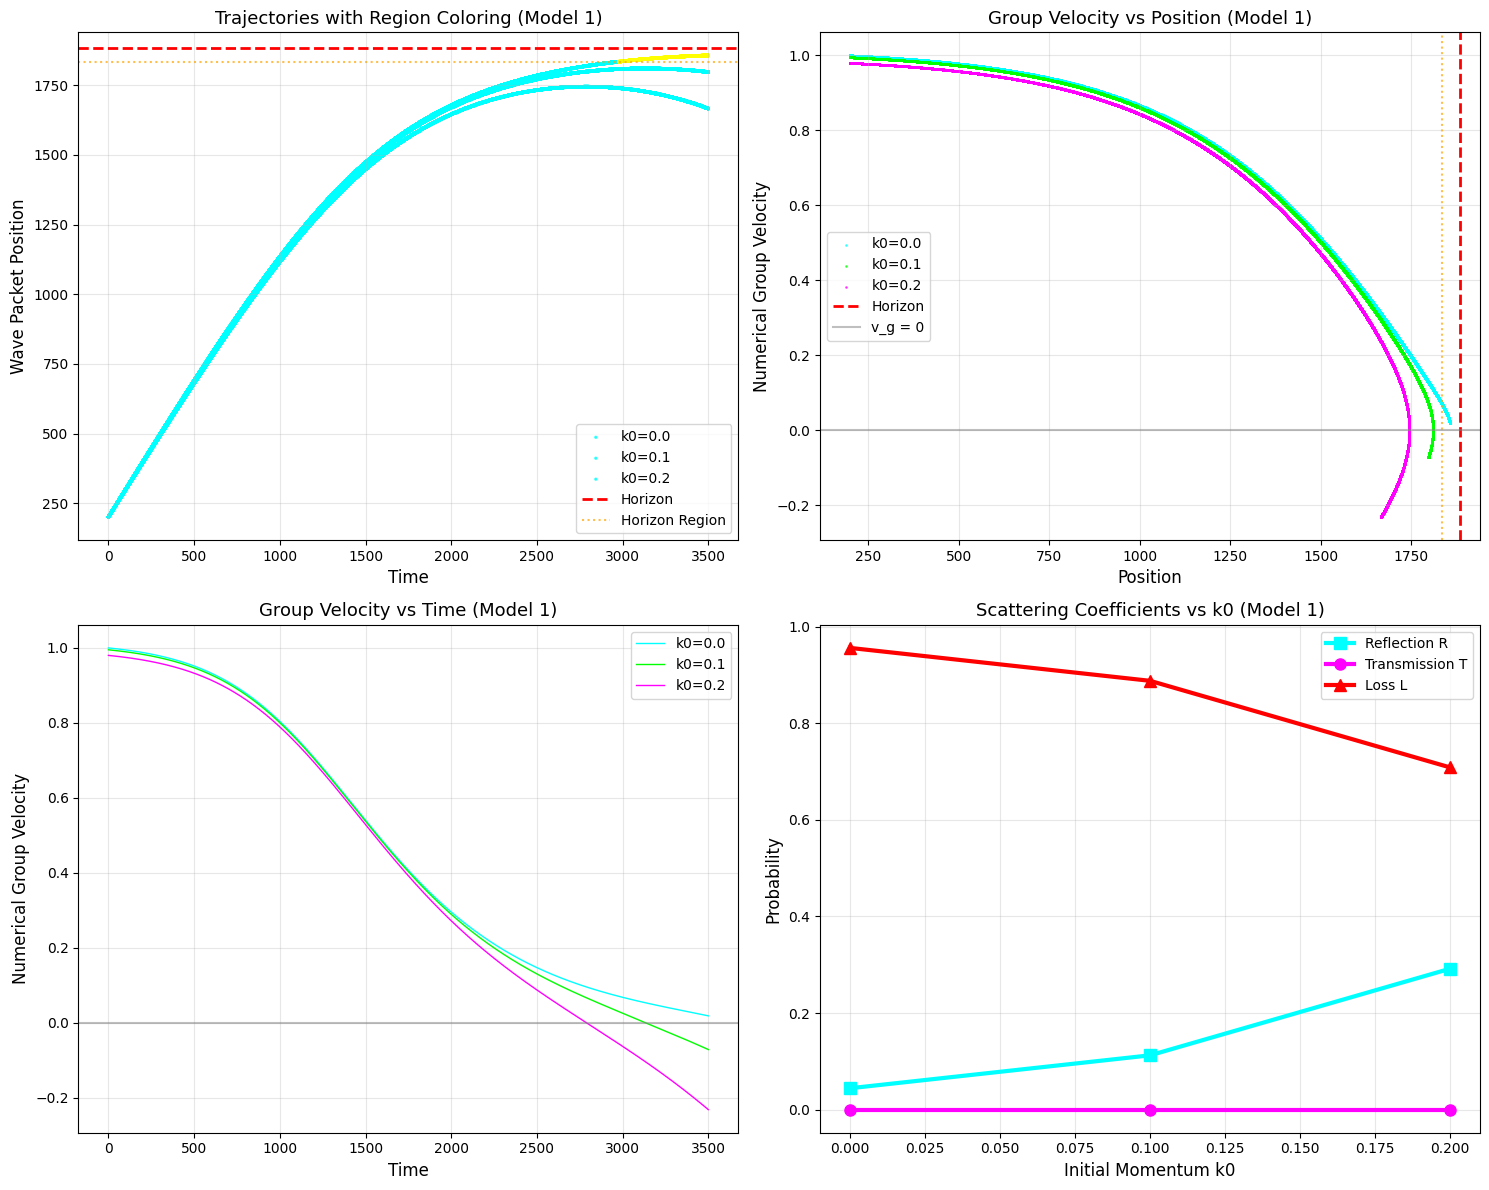

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



SUMMARY OF KEY FINDINGS - MODEL 1:
Horizon position: x = 1884.5
Horizon region: x = 1884.5143010338384 ± 50

Scattering behavior:
k0 = 0.0: R = 0.0443, T = 0.0000, Loss = 0.9557
k0 = 0.1: R = 0.1124, T = 0.0000, Loss = 0.8876
k0 = 0.2: R = 0.2917, T = 0.0000, Loss = 0.7083


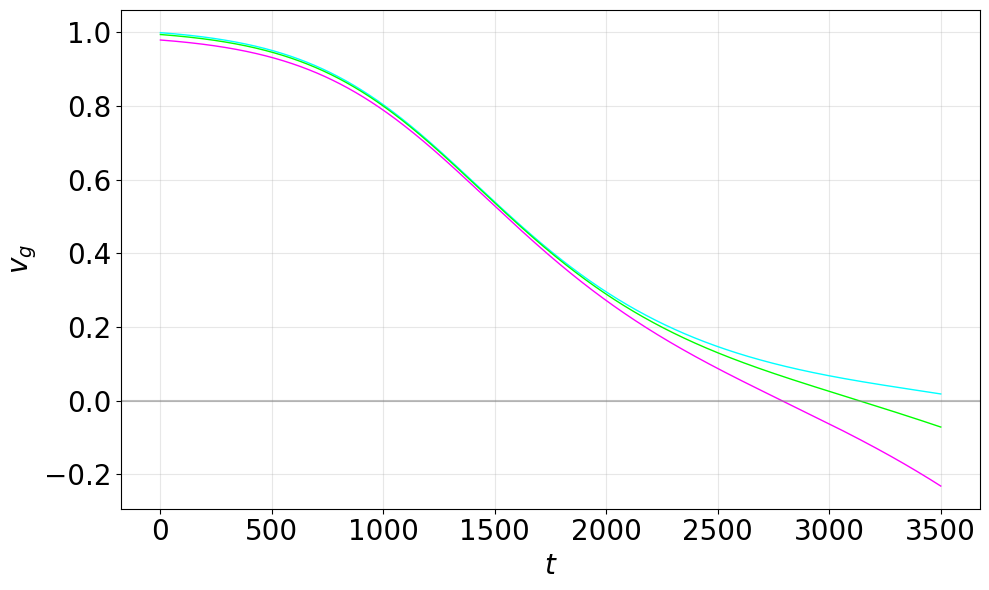

In [11]:
#Group Velocity Diagnostic Analysis - Model 1
print("\n" + "="*60)
print("GROUP VELOCITY DIAGNOSTIC ANALYSIS - MODEL 1")
print("="*60)

for i, k0 in enumerate(k0_values):
    print(f"\n--- Analysis for k0 = {k0} ---")
    
    # Get numerical trajectory data
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    vg_num_list = results[k0]['vg_num']
    
    # Define regions (Model 1: focus on approach and reflection)
    horizon_region = (x_horizon - horizon_interaction_width, x_horizon + horizon_interaction_width)
    approach_region = (0, x_horizon - horizon_interaction_width)
    
    # Analyze group velocity in each region
    vg_approach = []
    vg_horizon = [] 
    times_approach = []
    times_horizon = []
    
    for j, (x_pos, time_val) in enumerate(zip(x_c_list[1:], time_list[1:])):
        if j < len(vg_num_list):
            vg = vg_num_list[j]
            
            if approach_region[0] <= x_pos <= approach_region[1]:
                vg_approach.append(vg)
                times_approach.append(time_val)
            elif horizon_region[0] <= x_pos <= horizon_region[1]:
                vg_horizon.append(vg)
                times_horizon.append(time_val)
    
    # Calculate statistics
    if vg_approach:
        vg_approach_mean = np.mean(vg_approach)
        vg_approach_std = np.std(vg_approach)
        print(f"Approach Region (x < {x_horizon-horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_approach_mean:.6f} ± {vg_approach_std:.6f}")
        print(f"  Range: {min(vg_approach):.6f} to {max(vg_approach):.6f}")
        print(f"  Time spent: {max(times_approach)-min(times_approach) if times_approach else 0:.2f}")
    
    if vg_horizon:
        vg_horizon_mean = np.mean(vg_horizon)
        vg_horizon_std = np.std(vg_horizon)
        vg_horizon_min = min(vg_horizon)
        print(f"Horizon Region (x = {x_horizon} ± {horizon_interaction_width}):")
        print(f"  Mean v_g = {vg_horizon_mean:.6f} ± {vg_horizon_std:.6f}")
        print(f"  Minimum v_g = {vg_horizon_min:.6f}")
        print(f"  Range: {min(vg_horizon):.6f} to {max(vg_horizon):.6f}")
        print(f"  Time spent: {max(times_horizon)-min(times_horizon) if times_horizon else 0:.2f}")
        
        # Check if wave packet stops or reflects
        if abs(vg_horizon_min) < 1e-3:
            print(f"  → FREEZES at horizon (v_g ≈ {vg_horizon_min:.6f})")
        elif vg_horizon_min < 0:
            print(f"  → REFLECTS from horizon (v_g changes sign)")
        else:
            print(f"  → SLOWS near horizon (min v_g = {vg_horizon_min:.6f})")
    else:
        print(f"Never entered horizon region (turned before reaching it)")
    
    # Reflection analysis
    T = T_values[i]
    R = R_values[i]
    Loss = Loss_values[i]
    print(f"Scattering Results:")
    print(f"  Reflection: R = {R:.4f}")
    print(f"  Transmission: T = {T:.4f}")
    print(f"  Loss: L = {Loss:.4f}")
    
    if R > 0.9:
        print(f"  → STRONG REFLECTION (R > 90%)")
    elif R > 0.5:
        print(f"  → PARTIAL REFLECTION (50% < R < 90%)")
    else:
        print(f"  → WEAK REFLECTION (R < 50%)")

# ===== Plot Group Velocity Analysis =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Trajectories with region coloring (approach/horizon only)
ax1 = axes[0, 0]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    
    # Color code by region (only approach and horizon for Model 1)
    colors_regions = []
    for x_pos in x_c_list:
        if x_pos < x_horizon - horizon_interaction_width:
            colors_regions.append('cyan')  # Approach
        else:
            colors_regions.append('yellow')  # Horizon region
    
    ax1.scatter(time_list, x_c_list, c=colors_regions, s=2, alpha=0.7, label=f'k0={k0}')
    
ax1.axhline(y=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax1.axhline(y=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7, label='Horizon Region')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Wave Packet Position', fontsize=12)
ax1.set_title('Trajectories with Region Coloring (Model 1)', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Group velocity vs position
ax2 = axes[0, 1]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(x_c_list):
        ax2.scatter(x_c_list, vg_num_list, color=colors[i], s=1, alpha=0.6, label=f'k0={k0}')
    
ax2.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax2.axvline(x=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='v_g = 0')
ax2.set_xlabel('Position', fontsize=12)
ax2.set_ylabel('Numerical Group Velocity', fontsize=12)
ax2.set_title('Group Velocity vs Position (Model 1)', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Group velocity vs time
ax3 = axes[1, 0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        ax3.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Numerical Group Velocity', fontsize=12)
ax3.set_title('Group Velocity vs Time (Model 1)', fontsize=13)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Scattering coefficients vs initial momentum
ax4 = axes[1, 1]
ax4.plot(k0_values, R_values, 's-', color='cyan', linewidth=3, markersize=8, label='Reflection R')
ax4.plot(k0_values, T_values, 'o-', color='magenta', linewidth=3, markersize=8, label='Transmission T')
ax4.plot(k0_values, Loss_values, '^-', color='red', linewidth=3, markersize=8, label='Loss L')
ax4.set_xlabel('Initial Momentum k0', fontsize=12)
ax4.set_ylabel('Probability', fontsize=12)
ax4.set_title('Scattering Coefficients vs k0 (Model 1)', fontsize=13)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_group_velocity_diagnostics.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("SUMMARY OF KEY FINDINGS - MODEL 1:")
print("="*60)
print(f"Horizon position: x = {x_horizon:.1f}")
print(f"Horizon region: x = {x_horizon} ± {horizon_interaction_width}")
print("\nScattering behavior:")

for i, k0 in enumerate(k0_values):
    print(f"k0 = {k0}: R = {R_values[i]:.4f}, T = {T_values[i]:.4f}, Loss = {Loss_values[i]:.4f}")

# Plot 3: Group velocity vs time
plt.figure(figsize=(10, 6))
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        plt.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$v_g$', fontsize=20)
#plt.set_title('Group Velocity vs Time')
#ax3.legend()
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('E1_vg(t).eps', format='eps', dpi=600, bbox_inches='tight')
plt.savefig('E1_vg(t).png', format='png', dpi=600, bbox_inches='tight')
plt.show()